In [1]:
import mne
import os 
import sys
from matplotlib import pyplot as plt
import numpy as np
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline    import Pipeline
from sklearn.model_selection import train_test_split
import pickle


BASE_DIR = r'C:\Users\adoni\Documents\CurrentStudy'
sys.path.append(rf'{BASE_DIR}\src')

from globals import DEFAULT_SESSION
from preprocessing import preprocess_raw

In [ ]:
BANDS = {
            'delta': (1, 4),
            'theta': (4, 8),
            'alpha': (8, 12),
            'beta': (12, 30),
            'gamma': (30, 45)
        }

def extract_band_power_features(epochs, bands=BANDS):      
    psd_obj = epochs.compute_psd(method='welch', fmin=1, fmax=45, n_fft=200, verbose=False)
    psds = psd_obj.get_data()  # shape: (n_epochs, n_channels, n_freqs)
    freqs = psd_obj.freqs

    features = []
    for epoch_psd in psds:  # shape: (n_channels, n_freqs)
        epoch_feats = []
        for fmin, fmax in bands.values():
            freq_mask = (freqs >= fmin) & (freqs < fmax)
            band_power = epoch_psd[:, freq_mask].mean(axis=1)  # mean power per channel in band
            epoch_feats.extend(band_power)
        features.append(epoch_feats)

    return np.array(features)


def extract_rel_band_power(epochs, bands=BANDS):
    psd = epochs.compute_psd(method='welch', fmin=1, fmax=45,
                             n_fft=200, verbose=False)
    psds = psd.get_data()                # (n_epochs, n_ch, n_freqs)
    freqs = psd.freqs
    total_power = psds.mean(axis=2, keepdims=True)  # potencia total
    feats = []
    for ep in psds:                       # por epoch
        rel = []
        for fmin, fmax in bands.values():
            mask = (freqs>=fmin)&(freqs<fmax)
            bp = ep[:, mask].mean(axis=1)
            rel.append(bp / (total_power[0,:,0] + 1e-12))
        feats.append(np.log(np.concatenate(rel) + 1e-12))
    return np.array(feats)


def extract_time_features(epochs):
    # epochs.get_data() -> shape (n_epochs, n_channels, n_times)
    data = epochs.get_data()
    means = data.mean(axis=2)
    stds  = data.std(axis=2)
    # Puedes añadir skew, kurtosis, etc.
    return np.concatenate([means, stds], axis=1)  # shape (n_epochs, n_channels*2)


def extract_band_ratios(band_features, n_bands = 5):
    # band_features shape: (n_epochs, n_channels * n_bands)
    n_ch = band_features.shape[1] // n_bands
    bands = band_features.reshape(-1, n_bands, n_ch)  # (n_epochs, n_bands, n_ch)
    # Ejemplo: ratio alpha/beta
    theta = bands[:, 0, :]  # index 2: alpha
    beta = bands[:, 1, :]   # index 3: beta

    ratio = (theta + 1e-6) / (beta + 1e-6)
    return ratio


In [6]:
DATA_DIR = os.path.join(BASE_DIR, 'data', 'eeg')
SUBJECTS = ['002','003','005','006', '007', '008', '010','011','012']
CHANNELS = ['F7','F3','Fz','F4','F8','C3','Cz','C4','P7','P3','Pz','P4','P8']

all_epochs_wc = []
all_epochs_wi = []
files_name = []
for i, sub in enumerate(SUBJECTS):
    print(f'Processing subject {sub} ({i+1}/{len(SUBJECTS)})')
    clean_dir = os.path.join(DATA_DIR, f'sub-{sub}', DEFAULT_SESSION, 'raw-ICA-annot')
    if os.path.exists(clean_dir):
        for file_name in os.listdir(clean_dir):
            if file_name.endswith('.fif'):
                fname = os.path.join(clean_dir, file_name)
                files_name.append(file_name)
                raw = mne.io.read_raw_fif(fname, preload=True, verbose=False).pick(CHANNELS, verbose=False)
                preprocess_raw(raw, h_freq=48, interpolate_bads=True)
                raw.resample(250, npad='auto', verbose=False)  # Resample to 250 Hz
                raw.del_proj()  # Drop any existing projections                #raw.interpolate_bads(reset_bads=True, verbose=False)
                event_id = {'WC': 1, 'WI': 2}  # Definir los códigos de eventos esperados
                try:
                    events, _ = mne.events_from_annotations(raw, event_id=event_id, verbose=False)
                except Exception as e:
                    print(f"Error processing {file_name}: {e}")
                    continue
                try:
                    epocsh_wc = mne.Epochs(raw, events, event_id=1, tmin=-0.1, tmax=.8, 
                                        preload=True, verbose=False, reject={'eeg': 100e-6})
                    epochs_wi = mne.Epochs(raw, events, event_id=2, tmin=-0.1, tmax=.8, 
                                        preload=True, verbose=False, reject={'eeg': 100e-6})
                except Exception as e:
                    print(f"Error creating epochs for {file_name}: {e}")
                all_epochs_wc.append(epocsh_wc)
                all_epochs_wi.append(epochs_wi)


epochs_wc_concat = mne.concatenate_epochs(all_epochs_wc)
epochs_wi_concat = mne.concatenate_epochs(all_epochs_wi)

# Guardar las épocas concatenadas y los nombres de archivo
with open("epochs_wc_concat.pkl", "wb") as f:
    pickle.dump(epochs_wc_concat, f)
with open("epochs_wi_concat.pkl", "wb") as f:
    pickle.dump(epochs_wi_concat, f)
with open("files_name.pkl", "wb") as f:
    pickle.dump(files_name, f)

print("Épocas concatenadas y nombres de archivo guardados.")


Processing subject 002 (1/9)
Processing subject 003 (2/9)
Processing subject 005 (3/9)
Processing subject 006 (4/9)
Error processing sub-006_ses-S001_task-stroop_run-003_raw.fif: Could not find any of the events you specified.
Processing subject 007 (5/9)
Processing subject 008 (6/9)
Processing subject 010 (7/9)


C:\Users\adoni\Documents\CurrentStudy\src\preprocessing.py:33: RuntimeWarning: filter_length (8449) is longer than the signal (8446), distortion is likely. Reduce filter length or filter a longer signal.
  raw.filter(l_freq=l_freq,
C:\Users\adoni\Documents\CurrentStudy\src\preprocessing.py:33: RuntimeWarning: filter_length (8449) is longer than the signal (8045), distortion is likely. Reduce filter length or filter a longer signal.
  raw.filter(l_freq=l_freq,


Processing subject 011 (8/9)
Processing subject 012 (9/9)


C:\Users\adoni\Documents\CurrentStudy\src\preprocessing.py:33: RuntimeWarning: filter_length (8449) is longer than the signal (8425), distortion is likely. Reduce filter length or filter a longer signal.
  raw.filter(l_freq=l_freq,


Not setting metadata
309 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
315 matching events found
Applying baseline correction (mode: mean)
Épocas concatenadas y nombres de archivo guardados.


C:\Users\adoni\AppData\Local\Temp\ipykernel_22100\940773902.py:38: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs_wc_concat = mne.concatenate_epochs(all_epochs_wc)
C:\Users\adoni\AppData\Local\Temp\ipykernel_22100\940773902.py:39: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs_wi_concat = mne.concatenate_epochs(all_epochs_wi)


In [83]:
with open("epochs_wc_concat.pkl", "rb") as f:
    epochs_wc_concat = pickle.load(f)
with open("epochs_wi_concat.pkl", "rb") as f:
    epochs_wi_concat = pickle.load(f)
with open("files_name.pkl", "rb") as f:
    files_name = pickle.load(f)

In [91]:
time_feats_wc = extract_time_features(epochs_wc_concat)  
time_feats_wi = extract_time_features(epochs_wi_concat)  

band_feats_wc = extract_band_power_features(epochs_wc_concat) 
band_feats_wi = extract_band_power_features(epochs_wi_concat) 

rel_feats_wc = extract_rel_band_power(epochs_wc_concat)
rel_feats_wi = extract_rel_band_power(epochs_wi_concat)

ratio_feats_wc = extract_band_ratios(band_feats_wc)
ratio_feats_wi = extract_band_ratios(band_feats_wi)

In [ ]:
from sklearn.metrics import classification_report
import joblib

def aux_func2(
    X_train, X_test, y_train, y_test, name,
    scoring='accuracy',
    save_models=True,
    model_prefix=''
):
    """
    Entrena y evalúa SVM, RF y KNN con GridSearchCV.
    Devuelve un diccionario con los mejores modelos y reports.
    """

    # Definir pipelines y grids
    models = {
        'SVM': {
            'pipeline': Pipeline([('scaler', StandardScaler()), ('clf', SVC())]),
            'param_grid': {
                'clf__C': [1e-3, 1e-1, 1, 10],
                'clf__kernel': ['linear', 'rbf'],
                'clf__gamma': ['scale', 'auto']
            }
        },
        'RandomForest': {
            'pipeline': Pipeline([('scaler', StandardScaler()), ('clf', RandomForestClassifier())]),
            'param_grid': {
                'clf__n_estimators': [40, 50, 100, 200, 300, 400, 500],
                'clf__max_depth': [None, 10, 2, 30, 50, 70, 90, 110]
            }
        },
        'KNN': {
            'pipeline': Pipeline([('scaler', StandardScaler()), ('clf', KNeighborsClassifier())]),
            'param_grid': {
                'clf__n_neighbors': [7, 8, 9, 11, 12, 13, 14, 15],
                'clf__metric': ['euclidean', 'manhattan', 'minkowski']
            }
        }
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    grids = {}
    reports = {}
    for model_name, cfg in models.items():
        grid = GridSearchCV(cfg['pipeline'], cfg['param_grid'], cv=cv, scoring=scoring)
        grid.fit(X_train, y_train)
        grids[model_name] = grid
        y_pred = grid.predict(X_test)
        report = classification_report(y_test, y_pred, target_names=['WC', 'WI'], output_dict=True)
        reports[model_name] = report
        print(f"\n=== {model_name} ({name}) ===")
        print("Best CV score:", grid.best_score_)
        print("Best params:", grid.best_params_)
        print(classification_report(y_test, y_pred, target_names=['WC', 'WI']))
        # Guardar modelo
        if save_models:
            path = os.path.join(BASE_DIR, 'models', 'stroop')
            fname = f"{model_prefix}{name.replace(' ', '_')}_best_{model_name.lower()}.joblib"
            full_path = os.path.join(path, fname)
            joblib.dump(grid.best_estimator_, full_path)
    return grids, reports

In [110]:
feats_wc = np.concatenate([band_feats_wc, rel_feats_wc, time_feats_wc], axis=1)  
feats_wi = np.concatenate([band_feats_wi, rel_feats_wi, time_feats_wi], axis=1)  
X = np.concatenate([feats_wc, feats_wi], axis=0)  
y = np.array([0] * len(feats_wc) + [1] * len(feats_wi))  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# print train and test set shapes
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
#print train and test proportions eg train set: 80%, test set: 20%
print(f"Train set: {len(X_train)} samples, Test set: {len(X_test)} samples")

# print number of observations in each class and proportion
print(f"Training set: {len(y_train)} samples, WC: {np.sum(y_train==0)}, WI: {np.sum(y_train==1)}")
print(f"Test set: {len(y_test)} samples, WC: {np.sum(y_test==0)}, WI: {np.sum(y_test==1)}")
# Now print like porcentage
print(f"Training set: {len(y_train)} samples, WC: {np.sum(y_train==0)/len(y_train)*100:.2f}%, WI: {np.sum(y_train==1)/len(y_train)*100:.2f}%")
print(f"Test set: {len(y_test)} samples, WC: {np.sum(y_test==0)/len(y_test)*100:.2f}%, WI: {np.sum(y_test==1)/len(y_test)*100:.2f}%")


feats_wc_1 = np.concatenate([time_feats_wc], axis=1)  
feats_wi_1 = np.concatenate([time_feats_wi], axis=1)  

X_1 = np.concatenate([feats_wc_1, feats_wi_1], axis=0)  # (n_epochs_total, n_features)
y_1 = np.array([0] * len(feats_wc_1) + [1] * len(feats_wi_1))  # 0 for WC, 1 for WI

X_train1, X_test1, y_train1, y_test1 = train_test_split(X_1, y_1, test_size=0.2, random_state=42, stratify=y)

# do it for time_feats + band_feats
feats_wc_2 = np.concatenate([band_feats_wc, time_feats_wc], axis=1)  
feats_wi_2 = np.concatenate([band_feats_wi, time_feats_wi], axis=1)  
X_2 = np.concatenate([feats_wc_2, feats_wi_2], axis=0)  # (n_epochs_total, n_features)
y_2 = np.array([0] * len(feats_wc_2) + [1] * len(feats_wi_2))  # 0 for WC, 1 for WI
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_2, y_2, test_size=0.2, random_state=42, stratify=y)

# do it for time_feats + band_feats + ratio
feats_wc_3 = np.concatenate([band_feats_wc, time_feats_wc, ratio_feats_wc], axis=1)  
feats_wi_3 = np.concatenate([band_feats_wi, time_feats_wi, ratio_feats_wi], axis=1)  
X_3 = np.concatenate([feats_wc_3, feats_wi_3], axis=0)  # (n_epochs_total, n_features)
y_3 = np.array([0] * len(feats_wc_3) + [1] * len(feats_wi_3))  # 0 for WC, 1 for WI
X_train3, X_test3, y_train3, y_test3 = train_test_split(X_3, y_3, test_size=0.2, random_state=42, stratify=y)

feats_wc_4 = np.concatenate([rel_feats_wc, time_feats_wc, ratio_feats_wc, band_feats_wc], axis=1)  
feats_wi_4 = np.concatenate([rel_feats_wi, time_feats_wi, ratio_feats_wi, band_feats_wi], axis=1)
X_4 = np.concatenate([feats_wc_4, feats_wi_4], axis=0)  # (n_epochs_total, n_features)
y_4 = np.array([0] * len(feats_wc_4) + [1] * len(feats_wi_4))  # 0 for WC, 1 for WI
X_train4, X_test4, y_train4, y_test4 = train_test_split(X_4, y_4, test_size=0.2, random_state=42, stratify=y)

feats_wc_5 = np.concatenate([rel_feats_wc, ratio_feats_wc, band_feats_wc], axis=1)  
feats_wi_5 = np.concatenate([rel_feats_wi, ratio_feats_wi, band_feats_wi], axis=1)
X_5 = np.concatenate([feats_wc_5, feats_wi_5], axis=0)  # (n_epochs_total, n_features)
y_5 = np.array([0] * len(feats_wc_5) + [1] * len(feats_wi_5))  # 0 for WC, 1 for WI
X_train5, X_test5, y_train5, y_test5 = train_test_split(X_5, y_5, test_size=0.2, random_state=42, stratify=y)

feats_wc_6 = np.concatenate([rel_feats_wc], axis=1)
feats_wi_6 = np.concatenate([rel_feats_wi], axis=1)
X_6 = np.concatenate([feats_wc_6, feats_wi_6], axis=0)  # (n_epochs_total, n_features)
y_6 = np.array([0] * len(feats_wc_6) + [1] * len(feats_wi_6))  # 0 for WC, 1 for WI
X_train6, X_test6, y_train6, y_test6 = train_test_split(X_6, y_6, test_size=0.2, random_state=42, stratify=y)


X_train shape: (499, 156), X_test shape: (125, 156)
Train set: 499 samples, Test set: 125 samples
Training set: 499 samples, WC: 247, WI: 252
Test set: 125 samples, WC: 62, WI: 63
Training set: 499 samples, WC: 49.50%, WI: 50.50%
Test set: 125 samples, WC: 49.60%, WI: 50.40%


In [111]:
grids6, reports6 = aux_func2(
    X_train6, X_test6, y_train6, y_test6, 'Relative Band Power')


=== SVM (Relative Band Power) ===
Best CV score: 0.8957575757575758
Best params: {'clf__C': 0.1, 'clf__gamma': 'scale', 'clf__kernel': 'linear'}
              precision    recall  f1-score   support

          WC       0.93      0.87      0.90        62
          WI       0.88      0.94      0.91        63

    accuracy                           0.90       125
   macro avg       0.91      0.90      0.90       125
weighted avg       0.91      0.90      0.90       125


=== RandomForest (Relative Band Power) ===
Best CV score: 0.8416969696969696
Best params: {'clf__max_depth': 50, 'clf__n_estimators': 300}
              precision    recall  f1-score   support

          WC       0.80      0.82      0.81        62
          WI       0.82      0.79      0.81        63

    accuracy                           0.81       125
   macro avg       0.81      0.81      0.81       125
weighted avg       0.81      0.81      0.81       125


=== KNN (Relative Band Power) ===
Best CV score: 0.72751515

In [94]:
grids, reports = aux_func2(X_train, X_test, y_train, y_test, 'band + rel + time', save_models=True, model_prefix='all_')


=== SVM (All Features) ===
Best CV score: 0.935878787878788
Best params: {'clf__C': 0.1, 'clf__gamma': 'scale', 'clf__kernel': 'linear'}
              precision    recall  f1-score   support

          WC       0.94      0.95      0.94        62
          WI       0.95      0.94      0.94        63

    accuracy                           0.94       125
   macro avg       0.94      0.94      0.94       125
weighted avg       0.94      0.94      0.94       125


=== RandomForest (All Features) ===
Best CV score: 0.8477777777777777
Best params: {'clf__max_depth': 90, 'clf__n_estimators': 200}
              precision    recall  f1-score   support

          WC       0.84      0.84      0.84        62
          WI       0.84      0.84      0.84        63

    accuracy                           0.84       125
   macro avg       0.84      0.84      0.84       125
weighted avg       0.84      0.84      0.84       125


=== KNN (All Features) ===
Best CV score: 0.6472525252525252
Best params: 

In [103]:
grids4, reports4 = aux_func2(X_train4, X_test4, y_train4, y_test4, 'band + rel + time + ratio', save_models=True, model_prefix='all_')


=== SVM (band + rel + time + ratio) ===
Best CV score: 0.9318787878787879
Best params: {'clf__C': 0.1, 'clf__gamma': 'scale', 'clf__kernel': 'linear'}
              precision    recall  f1-score   support

          WC       0.94      0.95      0.94        62
          WI       0.95      0.94      0.94        63

    accuracy                           0.94       125
   macro avg       0.94      0.94      0.94       125
weighted avg       0.94      0.94      0.94       125


=== RandomForest (band + rel + time + ratio) ===
Best CV score: 0.8617373737373738
Best params: {'clf__max_depth': 90, 'clf__n_estimators': 400}
              precision    recall  f1-score   support

          WC       0.84      0.85      0.85        62
          WI       0.85      0.84      0.85        63

    accuracy                           0.85       125
   macro avg       0.85      0.85      0.85       125
weighted avg       0.85      0.85      0.85       125


=== KNN (band + rel + time + ratio) ===
Best CV

In [105]:
grids5, reports5 = aux_func2(X_train5, X_test5, y_train5, y_test5, 'band + rel + ratio', save_models=True)


=== SVM (band + rel + ratio) ===
Best CV score: 0.933939393939394
Best params: {'clf__C': 0.1, 'clf__gamma': 'scale', 'clf__kernel': 'linear'}
              precision    recall  f1-score   support

          WC       0.94      0.94      0.94        62
          WI       0.94      0.94      0.94        63

    accuracy                           0.94       125
   macro avg       0.94      0.94      0.94       125
weighted avg       0.94      0.94      0.94       125


=== RandomForest (band + rel + ratio) ===
Best CV score: 0.8496767676767677
Best params: {'clf__max_depth': 50, 'clf__n_estimators': 200}
              precision    recall  f1-score   support

          WC       0.87      0.87      0.87        62
          WI       0.87      0.87      0.87        63

    accuracy                           0.87       125
   macro avg       0.87      0.87      0.87       125
weighted avg       0.87      0.87      0.87       125


=== KNN (band + rel + ratio) ===
Best CV score: 0.639232323232

In [107]:
grids1, reports1 = aux_func2(X_train1, X_test1, y_train1, y_test1, name='time')

c:\Users\adoni\Documents\CurrentStudy\eeg_env_312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\adoni\Documents\CurrentStudy\eeg_env_312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\adoni\Documents\CurrentStudy\eeg_env_312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr


=== SVM (time) ===
Best CV score: 0.505010101010101
Best params: {'clf__C': 0.001, 'clf__gamma': 'scale', 'clf__kernel': 'linear'}
              precision    recall  f1-score   support

          WC       0.00      0.00      0.00        62
          WI       0.50      1.00      0.67        63

    accuracy                           0.50       125
   macro avg       0.25      0.50      0.34       125
weighted avg       0.25      0.50      0.34       125


=== RandomForest (time) ===
Best CV score: 0.5111515151515151
Best params: {'clf__max_depth': 50, 'clf__n_estimators': 100}
              precision    recall  f1-score   support

          WC       0.45      0.50      0.47        62
          WI       0.45      0.40      0.42        63

    accuracy                           0.45       125
   macro avg       0.45      0.45      0.45       125
weighted avg       0.45      0.45      0.45       125


=== KNN (time) ===
Best CV score: 0.5151313131313131
Best params: {'clf__metric': 'manha

In [108]:
grids2, reports2 = aux_func2(X_train2, X_test2, y_train2, y_test2, name='time + band')


=== SVM (time + band) ===
Best CV score: 0.509030303030303
Best params: {'clf__C': 1, 'clf__gamma': 'scale', 'clf__kernel': 'linear'}
              precision    recall  f1-score   support

          WC       0.47      0.53      0.50        62
          WI       0.47      0.41      0.44        63

    accuracy                           0.47       125
   macro avg       0.47      0.47      0.47       125
weighted avg       0.47      0.47      0.47       125


=== RandomForest (time + band) ===
Best CV score: 0.497010101010101
Best params: {'clf__max_depth': 10, 'clf__n_estimators': 100}
              precision    recall  f1-score   support

          WC       0.48      0.52      0.50        62
          WI       0.48      0.44      0.46        63

    accuracy                           0.48       125
   macro avg       0.48      0.48      0.48       125
weighted avg       0.48      0.48      0.48       125


=== KNN (time + band) ===
Best CV score: 0.49517171717171726
Best params: {'clf

In [109]:
grids3, reports3 = aux_func2(X_train3, X_test3, y_train3, y_test3, name='time + band + ratio')


=== SVM (time + band + ratio) ===
Best CV score: 0.511010101010101
Best params: {'clf__C': 1, 'clf__gamma': 'scale', 'clf__kernel': 'linear'}
              precision    recall  f1-score   support

          WC       0.45      0.48      0.47        62
          WI       0.46      0.43      0.44        63

    accuracy                           0.46       125
   macro avg       0.46      0.46      0.46       125
weighted avg       0.46      0.46      0.46       125


=== RandomForest (time + band + ratio) ===
Best CV score: 0.5170505050505051
Best params: {'clf__max_depth': 70, 'clf__n_estimators': 40}
              precision    recall  f1-score   support

          WC       0.50      0.50      0.50        62
          WI       0.51      0.51      0.51        63

    accuracy                           0.50       125
   macro avg       0.50      0.50      0.50       125
weighted avg       0.50      0.50      0.50       125


=== KNN (time + band + ratio) ===
Best CV score: 0.495131313131

In [95]:
grids

{'SVM': GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
              estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                        ('clf', SVC())]),
              param_grid={'clf__C': [0.001, 0.1, 1, 10],
                          'clf__gamma': ['scale', 'auto'],
                          'clf__kernel': ['linear', 'rbf']},
              scoring='accuracy'),
 'RandomForest': GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
              estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                        ('clf', RandomForestClassifier())]),
              param_grid={'clf__max_depth': [None, 10, 2, 30, 50, 70, 90, 110],
                          'clf__n_estimators': [40, 50, 100, 200, 300, 400,
                                                500]},
              scoring='accuracy'),
 'KNN': GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
      

In [ ]:
rf_model_more = grids5['RandomForest'].best_estimator_.named_steps['clf']
rf_model_rp = grids6['RandomForest'].best_estimator_.named_steps['clf']

In [196]:
# Define feature mapping function
def map_feature_indices():
    """Crea un mapeo de índices de características a su descripción significativa."""
    feature_names = []
    band_names = ['delta', 'theta', 'alpha', 'beta', 'gamma']

    for band in band_names:
        for ch in CHANNELS:
            feature_names.append(f"Rel_power_{band}_{ch}")
    for ch in CHANNELS:
        feature_names.append(f"Ratio_{ch}")
    for band in band_names:
        for ch in CHANNELS:
            feature_names.append(f"Power_{band}_{ch}")
    
    return feature_names

# Define feature mapping function
feature_names_more = map_feature_indices()

In [197]:
# Define feature mapping function
def map_feature_indices():
    """Crea un mapeo de índices de características a su descripción significativa."""
    feature_names = []
    band_names = ['delta', 'theta', 'alpha', 'beta', 'gamma']

    for band in band_names:
        for ch in CHANNELS:
            feature_names.append(f"Rel_power_{band}_{ch}")
    
    return feature_names

# Define feature mapping function
feature_names_rp = map_feature_indices()

In [198]:
import pandas as pd

# extract feature importances for both models
importances_more = rf_model_more.feature_importances_
importances_rp = rf_model_rp.feature_importances_

In [204]:
import numpy as np

def mostrar_top_caracteristicas(importances, feature_names, top_n=20):
    """
    Muestra las top_n características más importantes con sus nombres y porcentajes.
    Args:
        importances (np.ndarray): Importancias de las características.
        feature_names (list): Lista de nombres de las características.
        top_n (int): Número de características a mostrar.
    """
    import matplotlib.pyplot as plt

    indices = np.argsort(importances)[::-1]
    importance_percentages = (importances / importances.sum()) * 100

    print(f"Top {top_n} características más importantes:")
    for i in range(min(top_n, len(importances))):
        idx = indices[i]
        name = feature_names[idx] if idx < len(feature_names) else f"Feature {idx}"
        print(f"{i+1}. {name}: {importances[idx]:.4f} ({importance_percentages[idx]:.2f}%)")

    # Gráfico de barras
    plt.figure(figsize=(14, 6))
    plt.title(f"Top {top_n} most important features")
    plt.bar(range(top_n), importances[indices[:top_n]], align='center')
    x_labels = [feature_names[indices[i]] if indices[i] < len(feature_names) else f"Feature {indices[i]}" for i in range(top_n)]
    plt.xticks(range(top_n), x_labels, rotation=45, ha='right')
    plt.xlabel("Features")
    plt.ylabel("Importance")
    plt.tight_layout()
    plt.show()

Top 30 características más importantes:
1. Rel_power_beta_P8: 0.0616 (6.16%)
2. Rel_power_gamma_P8: 0.0332 (3.32%)
3. Rel_power_theta_P8: 0.0302 (3.02%)
4. Rel_power_gamma_F7: 0.0294 (2.94%)
5. Rel_power_beta_F7: 0.0293 (2.93%)
6. Rel_power_delta_P8: 0.0236 (2.36%)
7. Rel_power_alpha_P8: 0.0226 (2.26%)
8. Rel_power_theta_F7: 0.0149 (1.49%)
9. Rel_power_theta_C3: 0.0115 (1.15%)
10. Rel_power_beta_Cz: 0.0114 (1.14%)
11. Rel_power_alpha_F7: 0.0110 (1.10%)
12. Power_delta_P8: 0.0104 (1.04%)
13. Rel_power_gamma_Cz: 0.0104 (1.04%)
14. Rel_power_beta_C4: 0.0102 (1.02%)
15. Power_beta_P8: 0.0101 (1.01%)
16. Rel_power_beta_P3: 0.0097 (0.97%)
17. Rel_power_gamma_P7: 0.0094 (0.94%)
18. Rel_power_beta_P7: 0.0094 (0.94%)
19. Rel_power_alpha_P7: 0.0094 (0.94%)
20. Rel_power_delta_F7: 0.0091 (0.91%)
21. Power_beta_F7: 0.0090 (0.90%)
22. Rel_power_theta_P7: 0.0084 (0.84%)
23. Rel_power_alpha_Cz: 0.0084 (0.84%)
24. Rel_power_beta_Fz: 0.0083 (0.83%)
25. Power_gamma_F7: 0.0080 (0.80%)
26. Rel_power_delta

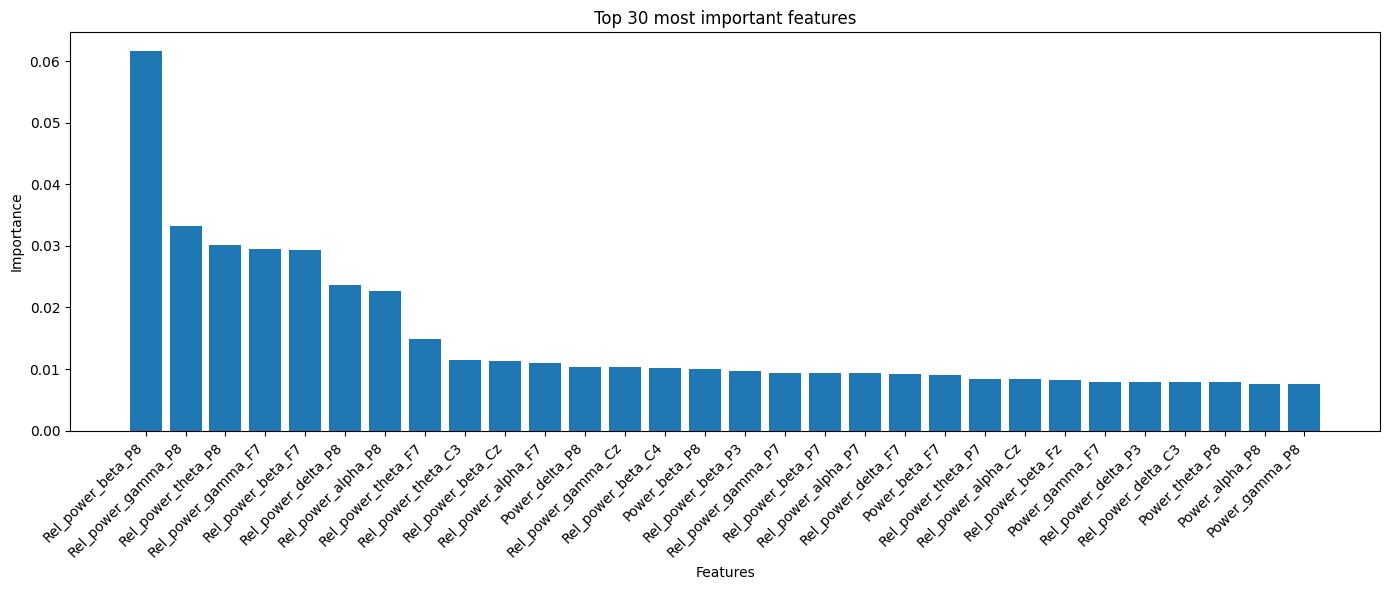

In [205]:
mostrar_top_caracteristicas(importances_more, feature_names_more, top_n=30)

In [ ]:
importances_more

In [212]:
def plot_all_importances(model, model_name):
    #get the most important features
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    #Plot the feature importances
    plt.figure(figsize=(10, 6))
    plt.title(f"Feature importances - {model_name}")
    plt.bar(range(model.n_features_in_ ), importances[indices], align='center')
    plt.xlim([-1, model.n_features_in_])

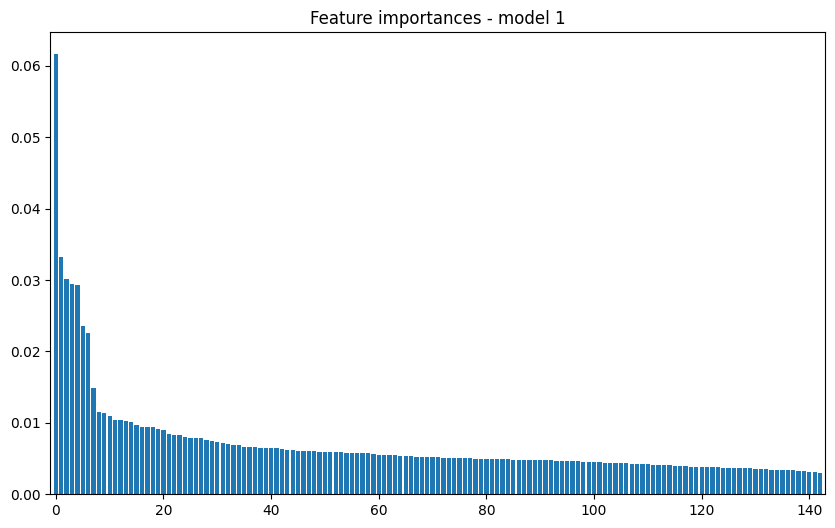

In [213]:
plot_all_importances(rf_model_more, "model 1")

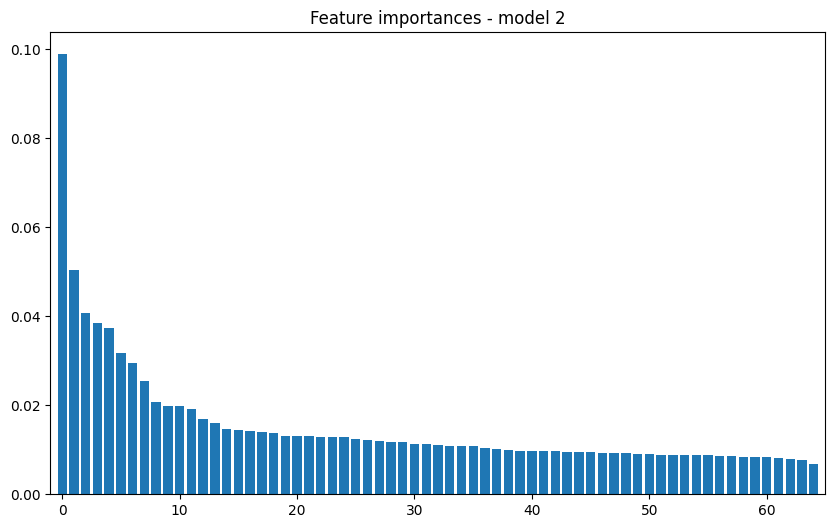

In [214]:
plot_all_importances(rf_model_rp, "model 2")

In [217]:
def num_features_for_percent(importances, percent=80):
    """
    Calcula el número mínimo de características necesarias para acumular al menos 'percent'% de la importancia total.
    Args:
        importances (np.ndarray): Importancias de las características.
        percent (float): Porcentaje objetivo de importancia acumulada (0-100).
    Returns:
        int: Número de características necesarias.
    """
    sorted_importances = np.sort(importances)[::-1]
    cumulative = np.cumsum(sorted_importances)
    total = cumulative[-1]
    cutoff = percent / 100 * total
    num_feats = np.searchsorted(cumulative, cutoff) + 1
    return num_feats


In [216]:
# Ejemplo de uso:
print(num_features_for_percent(importances_more, percent=80))
print(num_features_for_percent(importances_rp, percent=80))


93
43


In [218]:
# Obtener el número de características necesarias para acumular el 80% de la importancia
num_feats_80 = num_features_for_percent(importances_rp, percent=80)

# Ordenar los índices de importancia de mayor a menor
indices_ordenados = np.argsort(importances_rp)[::-1]

# Extraer los nombres de las características correspondientes
top_features_80_rp = [feature_names_rp[idx] for idx in indices_ordenados[:num_feats_80]]

In [219]:
# Filtrar las 20 características más importantes que no sean 'Rel_power_...'
feat_imp = pd.DataFrame({
    'feature': feature_names_more,
    'importance': importances_more
})
# Ordenar por importancia descendente
feat_imp = feat_imp.sort_values('importance', ascending=False).reset_index(drop=True)

# Seleccionar solo las que NO empiezan por 'Rel_power_'
feat_imp_no_rel = feat_imp[~feat_imp['feature'].str.startswith('Rel_power_')]

# Tomar las 20 más importantes de este subconjunto
top20_no_rel = feat_imp_no_rel.head(20)
print(top20_no_rel)

           feature  importance
11  Power_delta_P8    0.010395
14   Power_beta_P8    0.010066
20   Power_beta_F7    0.009011
24  Power_gamma_F7    0.007959
27  Power_theta_P8    0.007892
28  Power_alpha_P8    0.007618
29  Power_gamma_P8    0.007500
35  Power_delta_P4    0.006689
41  Power_delta_Pz    0.006434
42        Ratio_P8    0.006323
43  Power_theta_C3    0.006257
46  Power_delta_Fz    0.006052
47  Power_theta_Fz    0.006045
48  Power_theta_Pz    0.005999
49        Ratio_P7    0.005943
50  Power_alpha_F3    0.005909
54   Power_beta_C4    0.005838
57  Power_delta_F7    0.005774
60  Power_alpha_F8    0.005557
61   Power_beta_Fz    0.005535


In [220]:
top_feats = top20_no_rel['feature'].tolist() + top_features_80_rp
len(top_feats)

63

In [224]:
# Extraer nombres de canales únicos de top_feats
new_channels = set()
for feat in top_feats:
    for ch in CHANNELS:
        if ch in feat:
            new_channels.add(ch)
new_channels = sorted(new_channels)
print(new_channels)

['C3', 'C4', 'Cz', 'F3', 'F7', 'F8', 'Fz', 'P3', 'P4', 'P7', 'P8', 'Pz']


In [225]:
# Comparar CHANNELS con canales_unicos
print("Canales en CHANNELS pero no en canales_unicos:", set(CHANNELS) - set(new_channels))
print("Canales en canales_unicos pero no en CHANNELS:", set(new_channels) - set(CHANNELS))
print("Canales en ambos:", set(CHANNELS) & set(new_channels))

Canales en CHANNELS pero no en canales_unicos: {'F4'}
Canales en canales_unicos pero no en CHANNELS: set()
Canales en ambos: {'F3', 'P3', 'P8', 'Cz', 'Fz', 'C4', 'F8', 'Pz', 'F7', 'C3', 'P7', 'P4'}


In [229]:
from collections import Counter

# Extraer la banda de cada característica en top_feats
band_names = ['delta', 'theta', 'alpha', 'beta', 'gamma']
band_counts = Counter()

for feat in top_feats:
    for band in band_names:
        if band in feat:
            band_counts[band] += 1

total_feats = len(top_feats)
band_percentages = {band: (count / total_feats) * 100 for band, count in band_counts.items()}

print("Porcentaje de aparición de cada banda en top_feats:")
for band, perc in band_percentages.items():
    print(f"{band}: {perc:.2f}%")

Porcentaje de aparición de cada banda en top_feats:
delta: 23.81%
beta: 20.63%
gamma: 12.70%
theta: 20.63%
alpha: 19.05%


In [232]:
print('x')

x


In [226]:
# Suponiendo que tienes una matriz de características original (por ejemplo, X_4) y la lista top_feats ya definida

# Primero, creamos un mapeo de nombre de característica a índice en feature_names_more
feature_to_index = {name: idx for idx, name in enumerate(feature_names_more)}

# Obtenemos los índices de las características que están en top_feats y también en feature_names_more
selected_indices = [feature_to_index[feat] for feat in top_feats if feat in feature_to_index]

# Creamos la nueva matriz de características usando X_4 y los índices seleccionados
X_top = X_4[:, selected_indices]

print(f"Shape de la nueva matriz de características: {X_top.shape}")

Shape de la nueva matriz de características: (624, 63)


In [227]:
X_train_top, X_test_top, y_train_top, y_test_top = train_test_split(X_top, y_4, test_size=0.2, random_state=42, stratify=y_4)

In [228]:
grids_top, reports_top = aux_func2(
    X_train_top, X_test_top, y_train_top, y_test_top, 'Top Features',
    save_models=True, model_prefix='top_')


=== SVM (Top Features) ===
Best CV score: 0.9218181818181819
Best params: {'clf__C': 0.1, 'clf__gamma': 'scale', 'clf__kernel': 'linear'}
              precision    recall  f1-score   support

          WC       0.98      0.95      0.97        62
          WI       0.95      0.98      0.97        63

    accuracy                           0.97       125
   macro avg       0.97      0.97      0.97       125
weighted avg       0.97      0.97      0.97       125


=== RandomForest (Top Features) ===
Best CV score: 0.8657171717171718
Best params: {'clf__max_depth': 110, 'clf__n_estimators': 400}
              precision    recall  f1-score   support

          WC       0.86      0.87      0.86        62
          WI       0.87      0.86      0.86        63

    accuracy                           0.86       125
   macro avg       0.86      0.86      0.86       125
weighted avg       0.86      0.86      0.86       125


=== KNN (Top Features) ===
Best CV score: 0.7514949494949494
Best params